In [27]:
#http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html
#https://github.com/ericjeske/growth-workshop/blob/master/Churn%20Baby%20Churn.ipynb

from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

In [3]:
print "Column names:"
print col_names

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [4]:
to_show = col_names[:6] + col_names[-6:]

print "\nSample data:"
churn_df[to_show].head(6)


Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [5]:
# Isolate target data
churn_result = churn_df['Churn?']

In [6]:
y = np.where(churn_result == 'True.',1,0)

In [11]:
y.shape[0]


3333L

In [12]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [13]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [14]:
# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

In [15]:
X

array([[ 128.  ,    0.  ,    1.  , ...,    3.  ,    2.7 ,    1.  ],
       [ 107.  ,    0.  ,    1.  , ...,    3.  ,    3.7 ,    1.  ],
       [ 137.  ,    0.  ,    0.  , ...,    5.  ,    3.29,    0.  ],
       ..., 
       [  28.  ,    0.  ,    0.  , ...,    6.  ,    3.81,    2.  ],
       [ 184.  ,    1.  ,    0.  , ...,   10.  ,    1.35,    2.  ],
       [  74.  ,    0.  ,    1.  , ...,    4.  ,    3.7 ,    0.  ]])

In [16]:
print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [17]:
# This is important
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [18]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [34]:
a = run_cv(X,y,RF)

In [37]:
a[0:5]

array([0, 0, 0, 0, 0])

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X,y,GBC))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Logistic Regression:
0.861
Gradient Boosting Classifier
0.953
Support vector machines:
0.919
Random forest:
0.949
K-nearest-neighbors:
0.893


[[2819   31]
 [ 238  245]]


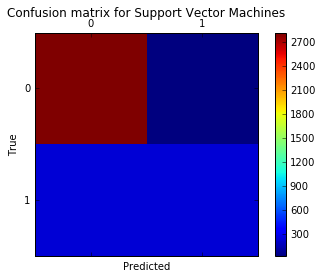

[[2824   26]
 [ 179  304]]


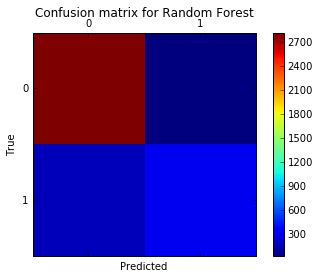

[[2804   46]
 [ 312  171]]


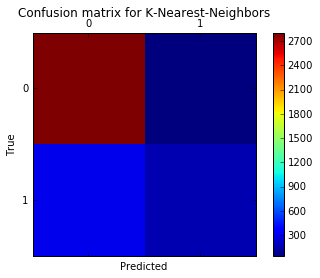

[[2821   29]
 [ 128  355]]


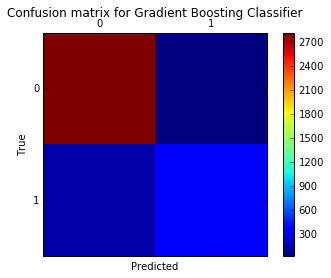

[[2764   86]
 [ 386   97]]


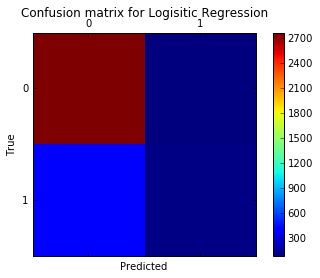

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

Support vector machines:


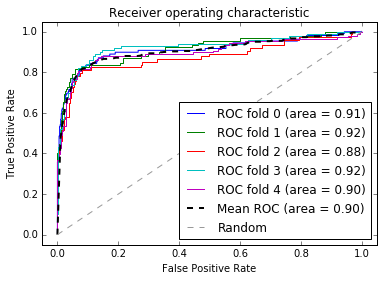

Random forests:


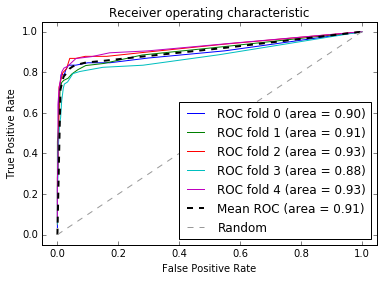

K-nearest-neighbors:


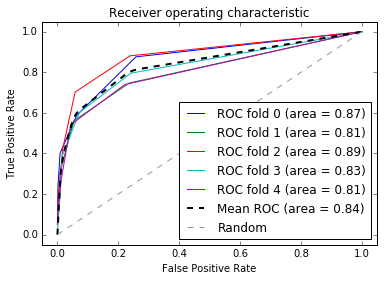

Gradient Boosting Classifier:


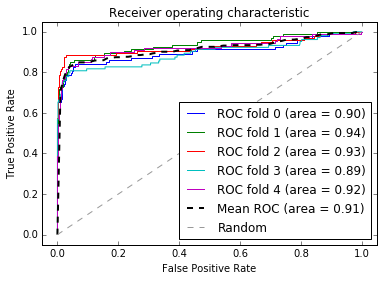

In [25]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print "Support vector machines:"
plot_roc(X,y,SVC,probability=True)

print "Random forests:"
plot_roc(X,y,RF,n_estimators=18)

print "K-nearest-neighbors:"
plot_roc(X,y,KNN)

print "Gradient Boosting Classifier:"
plot_roc(X,y,GBC)

Feature ranking:
1. Account Length (0.147624)
2. Int'l Plan (0.146943)
3. VMail Plan (0.094394)
4. VMail Message (0.076658)
5. Day Mins (0.054939)
6. Day Calls (0.036627)
7. Day Charge (0.035716)
8. Eve Mins (0.035000)
9. Eve Calls (0.026009)
10. Eve Charge (0.019584)


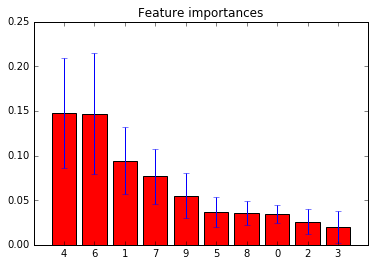

In [28]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

In [29]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [62]:
prob = run_prob_cv(X, y, RF) #returns probably of returning (0) and churning (1)

In [63]:
prob[0:5] #first 5


array([[ 0.9,  0.1],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       [ 0.5,  0.5],
       [ 1. ,  0. ]])

In [74]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
#counts = pd.value_counts(pred_churn)
#counts[:10]
pred_prob[0:10]
pred_churn[0:10] #2nd column

array([[ 0.8,  0.2],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       [ 0.6,  0.4],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       [ 0.6,  0.4],
       [ 0.9,  0.1],
       [ 0.7,  0.3],
       [ 0.7,  0.3]])

In [79]:
is_churn.shape # actual labels true/false

(3333L,)

In [80]:
pred_churn.shape # predicted labels probability

(3333L,)

In [69]:
counts = pd.value_counts(pred_churn)

In [66]:
counts

0.0    1736
0.1     731
0.2     262
0.3     137
0.8      85
0.9      81
0.7      70
0.6      62
1.0      60
0.4      56
0.5      53
dtype: int64

In [81]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    #print prob
    #print is_churn[pred_churn == prob]


In [82]:
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts


,pred_prob,count,true_prob
0,0.0,1736,0.025434
1,0.1,731,0.031507
2,0.2,262,0.053846
3,0.3,137,0.188525
4,0.4,56,0.315789
5,0.5,53,0.586667
6,0.6,62,0.827586
7,0.7,70,0.753846
8,0.8,85,0.987500
9,0.9,81,0.987952
